Input shape to the model: torch.Size([16, 1, 128, 426])
Input shape to the model: torch.Size([16, 1, 128, 426])
Input shape to the model: torch.Size([16, 1, 128, 426])
Input shape to the model: torch.Size([16, 1, 128, 426])
Input shape to the model: torch.Size([16, 1, 128, 426])
Input shape to the model: torch.Size([16, 1, 128, 426])
Input shape to the model: torch.Size([16, 1, 128, 426])
Input shape to the model: torch.Size([16, 1, 128, 426])
Input shape to the model: torch.Size([16, 1, 128, 426])
Epoch 1/100, Loss: 53248.70920
Epoch 2/100, Loss: 52931.59158
Epoch 3/100, Loss: 52381.61762
Epoch 4/100, Loss: 51880.13802
Epoch 5/100, Loss: 50780.23090
Epoch 6/100, Loss: 49357.10938
Epoch 7/100, Loss: 48211.85547
Epoch 8/100, Loss: 46363.75260
Epoch 9/100, Loss: 44555.55078
Epoch 10/100, Loss: 42804.19488
Epoch 11/100, Loss: 40958.00347
Epoch 12/100, Loss: 39385.74826
Epoch 13/100, Loss: 37959.30599
Epoch 14/100, Loss: 36394.86936
Epoch 15/100, Loss: 35160.50087
Epoch 16/100, Loss: 33703

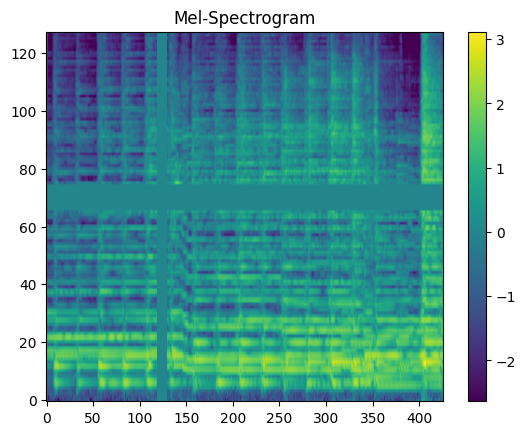

In [18]:
import torch
import torchaudio
import torchaudio.transforms as T
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
import torch.nn as nn
import torch.nn.functional as F

# ==================================================================== Preprocessing start
class AudioDataset(Dataset):
    def __init__(self, file_list, sample_rate=16000, n_fft=1024, hop_length=256, n_mels=128, augment=False):
        """
        Audio dataset for loading and preprocessing audio files into Mel-spectrograms.
        
        Args:
            file_list (list): List of file paths to audio files.
            sample_rate (int): Target sample rate for resampling.
            n_fft (int): FFT size for the STFT.
            hop_length (int): Hop length for the STFT.
            n_mels (int): Number of Mel filter banks.
            augment (bool): Whether to apply data augmentation.
        """
        self.file_list = file_list
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.augment = augment

        # Mel-spectrogram transform
        self.mel_transform = T.MelSpectrogram(
            sample_rate=self.sample_rate,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            n_mels=self.n_mels
        )

        # Normalization transform
        self.amplitude_to_db = T.AmplitudeToDB(stype="power", top_db=80)

        # Augmentation (optional)
        self.time_masking = T.TimeMasking(time_mask_param=20)
        self.freq_masking = T.FrequencyMasking(freq_mask_param=10)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # Load audio file
        file_path = self.file_list[idx]
        waveform, sr = torchaudio.load(file_path)

        # Resample if necessary
        if sr != self.sample_rate:
            resampler = T.Resample(orig_freq=sr, new_freq=self.sample_rate)
            waveform = resampler(waveform)

        # Convert to mono
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        # Apply Mel-spectrogram transform
        mel_spectrogram = self.mel_transform(waveform)

        # Convert amplitude to decibels
        mel_spectrogram = self.amplitude_to_db(mel_spectrogram)

        # Normalize across the dataset (optional: apply min-max normalization)
        mel_spectrogram = (mel_spectrogram - mel_spectrogram.mean()) / (mel_spectrogram.std() + 1e-6)

        # Apply augmentations if enabled
        if self.augment:
            mel_spectrogram = self.time_masking(mel_spectrogram)
            mel_spectrogram = self.freq_masking(mel_spectrogram)

        return mel_spectrogram
# ==================================================================== Preprocessing end

# ==================================================================== Vae architecture start


class SimplifiedVAE(nn.Module):
    def __init__(self, input_shape=(1, 128, 426), latent_dim=32):
        super(SimplifiedVAE, self).__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 128x426 -> 64x213
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # 64x213 -> 32x107
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # 32x107 -> 16x54
            nn.ReLU()
        )

        # Compute intermediate shape
        self.intermediate_shape = self.compute_conv_output_dim(input_shape)
        intermediate_dim = int(np.prod(self.intermediate_shape))

        # Latent space
        self.fc_mu = nn.Linear(intermediate_dim, latent_dim)
        self.fc_logvar = nn.Linear(intermediate_dim, latent_dim)

        # Decoder
        self.fc = nn.Linear(latent_dim, intermediate_dim)
        self.decoder = nn.Sequential(
            # 16x54 -> 32x107 (output_padding=(1,0))
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=(1,0)),
            nn.ReLU(),
            # 32x107 -> 64x213 (output_padding=(1,0))
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=(1,0)),
            nn.ReLU(),
            # 64x213 -> 128x426 (output_padding=(1,1))
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=(1,1)),
            nn.Tanh()
        )

    def compute_conv_output_dim(self, input_shape):
        dummy_input = torch.zeros(1, *input_shape)
        with torch.no_grad():
            dummy_output = self.encoder(dummy_input)
        return dummy_output.shape[1:]  # (C, H, W)

    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.fc(z).view(-1, *self.intermediate_shape)
        x = self.decoder(x)  # Should now be (B,1,128,426)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

def vae_loss(recon_x, x, mu, logvar, beta=0.1):
    # Now recon_x and x should match in size: [B,1,128,426]
    recon_loss = F.mse_loss(recon_x, x, reduction="sum")
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_div


# ==================================================================== Vae architecture end


# Helper function to create dataset and dataloader
def create_dataloader(folder_path, batch_size=16, augment=False):
    """
    Create a DataLoader for the dataset.

    Args:
        folder_path (str): Path to the folder containing audio files.
        batch_size (int): Batch size for DataLoader.
        augment (bool): Whether to apply data augmentation.

    Returns:
        DataLoader: DataLoader for the audio dataset.
    """
    # Get all .wav files in the folder
    file_list = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.wav')]
    dataset = AudioDataset(file_list, augment=augment)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader


def train_vae(model, dataloader, optimizer, epochs=100, device="cuda"):
    """
    Training loop for the Variational Autoencoder.

    Args:
        model: VAE model.
        dataloader: DataLoader for the dataset.
        optimizer: Optimizer for training.
        epochs: Number of training epochs.
        device: Device to use for training ("cuda" or "cpu").
    """
    model.to(device)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in dataloader:
            batch = batch.to(device)

            if epoch == 0:
                print(f"Input shape to the model: {batch.shape}")

            # Forward pass
            optimizer.zero_grad()
            recon_x, mu, logvar = model(batch)

            # Compute loss
            loss = vae_loss(recon_x, batch, mu, logvar)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader.dataset)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.5f}")


# Example usage
if __name__ == "__main__":
    folder_path = "ground_truth_others"
    batch_size = 16

    # Create DataLoader
    dataloader = create_dataloader(folder_path, batch_size=batch_size, augment=True)

    # Initialize model, optimizer
    input_shape = (1, 128, 430)  # Adjust based on your spectrogram dimensions
    latent_dim = 32
    vae = SimplifiedVAE(input_shape=input_shape, latent_dim=latent_dim)
    optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4)

    # Train the VAE
    train_vae(vae, dataloader, optimizer, epochs=100, device="cuda" if torch.cuda.is_available() else "cpu")

    # Visualize a sample
    import matplotlib.pyplot as plt
    for mel_spectrogram in dataloader:
        # Show the first spectrogram in the batch
        plt.imshow(mel_spectrogram[0].squeeze(0).numpy(), aspect="auto", origin="lower", cmap="viridis")
        plt.title("Mel-Spectrogram")
        plt.colorbar()
        plt.show()
        break
